In [123]:
import torchvision.models as models
from torchvision import transforms
import torch.nn as nn
import cv2
import torch
import requests
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [125]:


model = models.video.r3d_18(pretrained=True)  # R3D model pretrained on Kinetics-400
model.fc = nn.Linear(model.fc.in_features, 3) #Replace the final layer with another classification layer

for param in model.parameters():
    param.requires_grad=False        #no need to train the pretrained weights

for param in model.fc.parameters():   #we need to train the new weights 
    param.requires_grad = True
    
state_dict = torch.load("model.pth", map_location=torch.device("cpu"))
model.load_state_dict(state_dict)


<All keys matched successfully>

In [126]:
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert NumPy array to PIL Image
    transforms.Resize((112, 112)),  # Resize frame to 112x112
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Function to extract and preprocess frames
def prepare_video(video_path, num_frames=16):
    cap = cv2.VideoCapture(video_path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_indices = torch.linspace(0, total_frames - 1, num_frames).long()

    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx.item())
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        frames.append(transform(frame))
    
    cap.release()

    # Stack frames and format for the model
    video_tensor = torch.stack(frames)  # Shape: [T, C, H, W]
    video_tensor = video_tensor.permute(1, 0, 2, 3)  # [T, C, H, W] -> [C, T, H, W]
    return video_tensor.unsqueeze(0)  # Add batch dimension: [C, T, H, W] -> [B, C, T, H, W]

In [ ]:

def classify_video(video_path, model):
    # Prepare the video as input
    model.eval()
    input_tensor = prepare_video(video_path)
    
    input_tensor=input_tensor.to(
                                 )
    print(input_tensor.type())

    # Perform inference
    with torch.no_grad():
        output = model(input_tensor)  # Output shape: [B, num_classes]
        
        print(output)

    
    # Get predicted class index
    predicted_class_idx = torch.argmax(output,dim=1).item()
    # predicted_label = class_labels[predicted_class_idx]
    return predicted_class_idx



In [128]:
lossi=[] #for plotting the loss
sum_loss=0

def train_model(model,x_train,y_train,batch_size,max_iters=100):
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)
   # AdamW optimizer
    model.train()                                           # Setting the model in training mode  
    criterion=torch.nn.CrossEntropyLoss()     # Loss for classification
    sum_loss=0
    
    #Creates a minibatch of random examples
    def createbatch():  
        batch_indices = torch.randint(0, x_train.size(0), (batch_size,))   # Same int can be repeated tho
        x_batch=x_train[batch_indices]   
        y_batch=y_train[batch_indices]   
        return x_batch,y_batch
        
    
    
    for i in range(max_iters):
        x_batch,y_batch=createbatch()
        output=model(x_batch)
        optimizer.zero_grad()
        loss=criterion(output,y_batch)
        loss.backward()
        optimizer.step()
        print('iteration', i)
        sum_loss+=loss.item()
        
        
        if i%10 ==0:
            print('loss:',loss)
            print('\n')
            lossi.append(sum_loss/10)
            sum_loss=0

    

In [129]:
X=torch.load('video_tensors.pt')
Y = torch.load('labels.pt')
model = model.to(device)
X = X.to(device)
Y = Y.to(device)

print(X.shape)
print(Y.shape)


torch.Size([700, 3, 16, 112, 112])
torch.Size([700])


In [131]:
train_ratio = 0.8
num_samples = X.size(0)  

# Calculate the number of training samples
train_size = int(num_samples * train_ratio)
test_size = num_samples - train_size

# Create indices for the split
indices = torch.randperm(num_samples)  # Random permutation of indices

# Get the training and testing indices
train_indices = indices[:train_size]
test_indices = indices[train_size:]

# Split the data
X_train = X[train_indices]
Y_train = Y[train_indices]

X_test = X[test_indices]
Y_test = Y[test_indices]

# Now, X_train, Y_train, X_test, and Y_test contain the respective datasets


In [132]:
train_model(model,X_train,Y_train,32,1)

iteration 0
loss: tensor(0.1417, grad_fn=<NllLossBackward0>)




In [ ]:


# Classify the video
video_path = "beating.mp4"
label = classify_video(video_path, model)

labels={0:"non assault", 1:"alert",2:"assault"}
print(labels[label])




torch.FloatTensor
tensor([[ 0.5468, -4.6459,  1.4174]])
assault


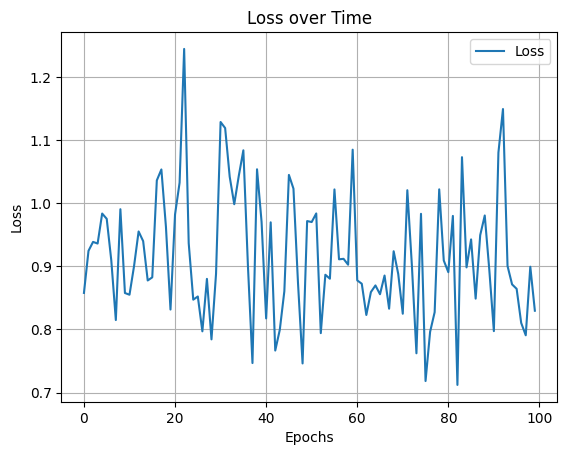

In [ ]:
import matplotlib.pyplot as plt


# Create a plot

plt.plot(lossi, label='Loss')
plt.xlabel('Epochs')  # X-axis label, e.g., number of epochs
plt.ylabel('Loss')    # Y-axis label
plt.title('Loss over Time')  # Title of the plot
plt.legend()  # Show legend
plt.grid(True)  # Optional: Add grid for better readability
plt.show()  # Display the plot

In [ ]:
import torch

# Assuming 'model' is your model
torch.save(model.state_dict(), 'model.pth')


In [ ]:
def validation_loss(model, x_val, y_val, batch_size):
    model.eval()  # Switch to evaluation mode
    criterion = torch.nn.CrossEntropyLoss()  # Loss for classification
    
    # Creates a minibatch for validation
    def create_val_batch():
        batch_indices = torch.randint(0, x_val.size(0), (batch_size,))
        x_val_batch = x_val[batch_indices]
        y_val_batch = y_val[batch_indices]
        return x_val_batch, y_val_batch
    
    sum_val_loss = 0
    correct = 0
    num_batches = len(x_val) // batch_size  # Number of batches for validation
    
    with torch.no_grad():  # Disable gradient computation
        for _ in range(num_batches):
            x_val_batch, y_val_batch = create_val_batch()
            val_output = model(x_val_batch)
            val_loss = criterion(val_output, y_val_batch)
            sum_val_loss += val_loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(val_output, 1)  # Get the predicted class (highest probability)
            correct += (predicted == y_val_batch).sum().item()  # Count correct predictions
    
    avg_val_loss = sum_val_loss / num_batches  # Average validation loss
    accuracy = correct / len(x_val)  # Accuracy for the entire validation set
    print(f'Validation loss: {avg_val_loss}, Validation Accuracy: {accuracy * 100:.2f}%')
    
    return avg_val_loss, accuracy


torch.Size([700, 3, 16, 112, 112])
torch.Size([700])


In [104]:
loss=validation_loss(model,X_test,Y_test,32)

Validation loss: 0.8713085204362869


0.8713085204362869